In [1]:
import umap
import copy
import argparse
import explainers
import parzen_windows
import numpy as np
import pickle
import sklearn
from load_datasets import *
from sklearn.metrics import accuracy_score

/home/minhvu/blue_minhvu/Python_geometric/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def get_tree_explanation(tree, v):
    t = tree.tree_
    nonzero = v.nonzero()[1]
    current = 0
    left_child = t.children_left[current]
    exp = set()
    while left_child != sklearn.tree._tree.TREE_LEAF:
        left_child = t.children_left[current]
        right_child = t.children_right[current]
        f = t.feature[current]
        if f in nonzero:
            exp.add(f)
        if v[0,f] < t.threshold[current]:
            current = left_child
        else:
            current = right_child
    return exp

class ExplanationEvaluator:
  def __init__(self, classifier_names=None):
    self.classifier_names = classifier_names
    if not self.classifier_names:
      self.classifier_names = ['l1logreg', 'tree']
    self.classifiers = {}
    
  def init_classifiers(self, dataset):
    self.classifiers[dataset] = {}
    for classifier in self.classifier_names:
      if classifier == 'l1logreg':
        try_cs = np.arange(.1,0,-.01)
        for c in try_cs:
          self.classifiers[dataset]['l1logreg'] = linear_model.LogisticRegression(penalty='l1', fit_intercept=True, C=c, solver='liblinear')
          self.classifiers[dataset]['l1logreg'].fit(self.train_vectors[dataset], self.train_labels[dataset])
          lengths = [len(x.nonzero()[0]) for x in self.classifiers[dataset]['l1logreg'].predict_proba(self.train_vectors[dataset])]
          if np.max(lengths) <= 10:
            #print 'Logreg for ', dataset, ' has mean length',  np.mean(lengths), 'with C=', c
            #print 'And max length = ', np.max(lengths)
            break
      if classifier == 'tree':
        self.classifiers[dataset]['tree'] = tree.DecisionTreeClassifier(random_state=1)
        self.classifiers[dataset]['tree'].fit(self.train_vectors[dataset], self.train_labels[dataset])
        lengths = [len(get_tree_explanation(self.classifiers[dataset]['tree'], self.train_vectors[dataset][i])) for i in range(self.train_vectors[dataset].shape[0])]
        #print 'Tree for ', dataset, ' has mean length',  np.mean(lengths)
        
  def load_datasets(self, dataset_names):
    self.train_data = {}
    self.train_labels = {}
    self.test_data = {}
    self.test_labels = {}
    for dataset in dataset_names:
      self.train_data[dataset], self.train_labels[dataset], self.test_data[dataset], self.test_labels[dataset], _ = LoadDataset(dataset)
    
  def vectorize_and_train(self):
    self.vectorizer = {}
    self.train_vectors = {}
    self.test_vectors = {}
    self.inverse_vocabulary = {}
    print('Vectorizing...')
    for d in self.train_data:
      self.vectorizer[d] = CountVectorizer(lowercase=False, binary=True, max_features = 1000)
      self.train_vectors[d] = self.vectorizer[d].fit_transform(self.train_data[d])
      self.test_vectors[d] = self.vectorizer[d].transform(self.test_data[d])
      terms = np.array(list(self.vectorizer[d].vocabulary_.keys()))
      indices = np.array(list(self.vectorizer[d].vocabulary_.values()))
      self.inverse_vocabulary[d] = terms[np.argsort(indices)]
    print('Done')
    print('Training...')
    for d in self.train_data:
      print(d)
      self.init_classifiers(d)
    print('Done')

  def measure_explanation_hability(self, explain_fn, max_examples=None):
    """Asks for explanations for all predictions in the train and test set, with
    budget = size of explanation. Returns two maps (train_results,
    test_results), from dataset to classifier to list of recalls"""
    budget = 10
    train_results = {}
    test_results = {}
    for d in self.train_data:
        train_results[d] = {}
        test_results[d] = {}
        print('Dataset:', d)
        for c in self.classifiers[d]:
            train_results[d][c] = []
            test_results[d][c] = []
            if c == 'l1logreg':
                c_features = self.classifiers[d][c].coef_.nonzero()[1]
            print('classifier:', c)
            
            for i in range(len(self.test_data[d])):
                if c == 'l1logreg':
                    true_features = set([x for x in self.test_vectors[d][i].nonzero()[1] if x in c_features])
                elif c == 'tree':
                    true_features = get_tree_explanation(self.classifiers[d][c], self.test_vectors[d][i])
                if len(true_features) == 0:
                    continue
                    
                to_get = budget
                exp_features = set(map(lambda x:x[0],
                explain_fn(self.test_vectors[d].todense()[i], self.test_labels[d][i] ,self.classifiers[d][c], to_get, d)))
                test_results[d][c].append(float(len(true_features.intersection(exp_features))) / len(true_features))
                if max_examples and i >= max_examples:
                    break
    return train_results, test_results

  def measure_explanation_fp(self, explain_fn, max_examples=None, method = 'notemap', budget = 10, feat_only = False, return_feat = False):

    test_recalls = {}
    test_fps = {}
    ex_feats = {}
    for d in self.train_data:
        train_results[d] = {}
        test_recalls[d] = {}
        test_fps[d] = {}
        ex_feats[d] = {}
        test_vectors = self.test_vectors[d].todense()

        for c in self.classifiers[d]:
            train_results[d][c] = []
            test_recalls[d][c] = []
            test_fps[d][c] = []
            ex_feats[d][c] = []
            if c == 'l1logreg':
                c_features = self.classifiers[d][c].coef_.nonzero()[1]
        
            
            for i in range(len(self.test_data[d])):
                if c == 'l1logreg':
                    if feat_only == True:
                        input_features = set([x for x in self.test_vectors[d][i].nonzero()[1]])
                        true_features = set([x for x in self.test_vectors[d][i].nonzero()[1] if x in c_features])
                    else:
                        true_features = set(c_features)
                elif c == 'tree':
                    true_features = set(get_tree_explanation(self.classifiers[d][c], self.test_vectors[d][i]))
                if len(true_features) == 0:
                    continue
                    
                to_get = budget
                if method != 'emap':
                    exp_features = set(map(lambda x:x[0],
                    explain_fn(test_vectors[i], self.test_labels[d][i] ,self.classifiers[d][c], to_get, d)))
                else:
#                     print("Explain sample: ", i)
                    emap_features = explain_fn(test_vectors[i], self.test_labels[d][i], dataset=d)
                    emap_features_cond = []
                    if feat_only == True:
                        for feat in emap_features:
                            if feat[0] in input_features:
                                emap_features_cond.append(feat)
                    else:
                        emap_features_cond = emap_features
                    if len(emap_features) > to_get:
                        exp_features = set([x[0] for x in emap_features_cond[0:to_get]])
                    else:
                        exp_features = set([x[0] for x in emap_features_cond])
    
                if len(exp_features) == 0:
                    test_fps[d][c].append(0)
                else:
                    test_fps[d][c].append((len(exp_features) - float(len(true_features.intersection(exp_features)))) / len(exp_features))
                test_recalls[d][c].append((float(len(true_features.intersection(exp_features)))) / len(true_features))
                if return_feat == True:
                    ex_feats[d][c].append(exp_features)
                
                if max_examples and i >= max_examples:
                    break
    
    if return_feat == True:
        return test_recalls, test_fps, ex_feats
    else:
        return test_recalls, test_fps

DATASET -> 'multi_polarity_books', 'multi_polarity_kitchen', 'multi_polarity_dvd', 'multi_polarity_kitchen'

ALGORITHM -> 'l1logreg', 'tree'

EXPLAINER -> 'lime', 'parzen', 'greedy' or 'random'

In [3]:
# EMaP LIME
class EMaPLocalExplainer:
  def __init__(self,
               kernel_fn,
               base_data,
               clf_fn = None,
               radius = 1,
               num_samples=5000,
               low_distance = False,
               lasso=True,
               mean=None,
               return_mean=False,
               return_mapped=False,
               lambda_=None,
               verbose=True,
               positive=False):
    # Transform_classifier, transform_explainer,
    # transform_explainer_to_classifier all take raw data in, whatever that is.
    # perturb(x, num_samples) returns data (perturbed data in f'(x) form),
    # inverse_data (perturbed data in x form) and mapping, where mapping is such
    # that mapping[i] = j, where j is an index for x form.
    # distance_fn takes raw data in. what we're calling raw data is just x
    self.lambda_ = lambda_
    self.kernel_fn = kernel_fn
    self.base_data = base_data
    self.radius = radius
    self.low_distance = low_distance
    
    data = self.base_data
    self.mapper = umap.UMAP(n_components = 2, random_state = 21)
    self.mapper.fit(data)
    
    data_low = self.mapper.transform(data)
    Xt = np.transpose(data_low)
    XtX = np.dot(Xt,data_low)
    Xty = np.dot(Xt,data)
    self.matG = np.linalg.solve(XtX,Xty)
    Gu, Gd, Gv = np.linalg.svd(self.matG, full_matrices=False)
    
    self.noise_radius = radius
    gauss_ = np.random.normal(0, 1, size=data.shape)
    gauss_noise = gauss_
    plane_noise = np.zeros_like(gauss_noise)

    for d in range(Gv.shape[0]):
        proj = np.dot(gauss_noise, np.transpose(Gv[d]))
        for s in range(plane_noise.shape[0]):
            plane_noise[s] = plane_noise[s] + proj[s]*Gv[d]        
    ortho_noise = gauss_noise - plane_noise

    # noise
    ortho_norm = self.normalize(ortho_noise, self.radius)
    plane_norm = self.normalize(plane_noise, self.radius)
    gauss_norm = self.normalize(gauss_noise, self.radius)

    # point clouds
    self.perturbations = data + ortho_norm
    self.plane_perturbations = data + plane_norm
    self.gauss_perturbations = data + gauss_norm
    
    if clf_fn != None:
        if not hasattr(clf_fn, '__call__'):
            classifier_fn = clf_fn.predict_proba
        self.clf_fn = classifier_fn
        self.labels = self.clf_fn(self.perturbations)
    else:
        self.clf_fn = None
        self.labels = None
    
    self.low_data = self.mapper.transform(self.base_data)
    self.low_perturbations = self.mapper.transform(self.perturbations)
    
    self.num_samples = num_samples
    self.lasso = lasso
    self.mean = mean
    self.return_mapped=return_mapped
    self.return_mean = return_mean
    self.verbose = verbose
    self.positive=positive
    
  def reset(self):
    pass

  def normalize(self, v, r):
    return v/np.sqrt(np.sum(v**2))*r

  def data_labels_distances_mapping(self, raw_data, classifier_fn):
    data, labels, distances, mapping = self.data_labels_distances_mapping_fn(raw_data, classifier_fn, self.num_samples)
    return data, labels, distances, mapping

  def generate_lars_path(self, weighted_data, weighted_labels):
    X = weighted_data
    alphas, active, coefs = linear_model.lars_path(X, weighted_labels, method='lasso', verbose=False, positive=self.positive)
    return alphas, coefs

  def explain_instance_with_data(self, data, labels, distances, label, num_features):
    weights = self.kernel_fn(distances)
    weighted_data = np.asarray(data) * weights[:, np.newaxis]
    if self.mean is None:
      mean = np.mean(labels[:, label])
    else:
      mean = self.mean
    shifted_labels = labels[:, label] - mean
    if self.verbose:
      print('mean', mean)
    weighted_labels = shifted_labels * weights
    used_features = range(weighted_data.shape[1])
    nonzero = used_features
    alpha = 1
    if self.lambda_:
      classif = linear_model.Lasso(alpha=self.lambda_, fit_intercept=False, positive=self.positive)
      classif.fit(weighted_data, weighted_labels)
      used_features = classif.coef_.nonzero()[0]
      if used_features.shape[0] == 0:
        if self.return_mean:
          return [], mean
        else:
          return []
    elif self.lasso:
      alphas, coefs = self.generate_lars_path(weighted_data, weighted_labels)
      for i in range(len(coefs.T) - 1, 0, -1):
        nonzero = coefs.T[i].nonzero()[0]
        if len(nonzero) <= num_features:
            chosen_coefs = coefs.T[i]
            alpha = alphas[i]
            break
      used_features = nonzero
    debiased_model = linear_model.Ridge(alpha=0, fit_intercept=False)
    debiased_model.fit(weighted_data[:, used_features], weighted_labels)
    if self.verbose:
      print('Prediction_local', debiased_model.predict(data[0, used_features].reshape(1, -1)) + mean, 'Right:', labels[0, label])
    if self.return_mean:
      return sorted(zip(used_features,
                  debiased_model.coef_),
                  key=lambda x:np.abs(x[1]), reverse=True), mean
    else:
      return sorted(zip(used_features,
                  debiased_model.coef_),
                  key=lambda x:np.abs(x[1]), reverse=True)
  def normalize(self, v, r):
    return v/np.sqrt(np.sum(v**2))*r

  def explain_instance(self,
                       input_instance,
                       label,
                       dataset=None):
        
    data = self.perturbations
    labels = self.labels
    
    if self.low_distance == False:
        distance_fn = lambda x : sklearn.metrics.pairwise.cosine_distances(input_instance,x)[0] * 100
        distances = distance_fn(data)
    else:
        low_data = self.low_perturbations
        low_base = self.mapper.transform(input_instance)
        distances = np.asarray([np.linalg.norm(low_data[i] - low_base) for i in range(low_data.shape[0])])
    
    return self.explain_instance_with_data(data, labels, distances, label, data.shape[1])



In [7]:
parser = argparse.ArgumentParser(description='Evaluate some explanations')
parser.add_argument('--dataset', '-d', type=str, required=True,help='dataset name')
parser.add_argument('--algorithm', '-a', type=str, required=True, help='algorithm_name')
parser.add_argument('--explainer', '-e', type=str, required=True, help='explainer name')
args = parser.parse_args("--dataset multi_polarity_books --algorithm l1logreg --explainer greedy ".split())

In [21]:
import evaluate_explanations
dataset = args.dataset
algorithm = args.algorithm

evaluator = ExplanationEvaluator(classifier_names=[args.algorithm])
from load_datasets import *

In [22]:
dataset

'multi_polarity_books'

In [23]:
LoadDataset(dataset)

(['reason upper both favorite provides her find challenging because  amazing alphabet my my wanted s already lower originally new boom boom book book book book type recommend old shown one crowd become instead who spy challenges knows old many many begin picture picture s i i i i  letter more not year him three beautiful beautiful old waldo others easy items shows out illustrations things some highly case letters letters letters chicka chicka bought besides',
  'white ve seriously school among among features saying actual hip honesty confident fiske fiske s colleges colleges colleges read read how just accurate guide guide guide guide guide blather she she re actually like different applying s more great interjected useful useful said guides lauded student student student impressed see s diversity profile many many lot vassar alum find although princeton me josh i also also also interjected oberlin oberlin oberlin i college college college best best ve profiles combines likes wealthy t

In [5]:
dataset = args.dataset
algorithm = args.algorithm
feat_only = args.feat_only
low_dim = args.low_dim  

evaluator = Evaluator.ExplanationEvaluator(classifier_names=[algorithm])
evaluator.load_datasets([dataset])
evaluator.vectorize_and_train()
explain_fn = None

print("Test method: ", args.explainer)
if args.explainer == 'emap':
print("Low dim? ", low_dim)

if args.explainer == 'lime':
    rho = 25
    kernel = lambda d: np.sqrt(np.exp(-(d**2) / rho ** 2))
    explainer = explainers.GeneralizedLocalExplainer(kernel, explainers.data_labels_distances_mapping_text, num_samples=15000, return_mean=False, verbose=False, return_mapped=True)
    explain_fn = explainer.explain_instance
elif args.explainer == 'parzen':
    sigmas = {'multi_polarity_electronics': {'tree': 0.5,
    'l1logreg': 1},
    'multi_polarity_kitchen': {'tree': 0.75, 'l1logreg': 2.0},
    'multi_polarity_dvd': {'tree': 8.0, 'l1logreg': 1},
    'multi_polarity_books': {'tree': 2.0, 'l1logreg': 2.0}}

    explainer = parzen_windows.ParzenWindowClassifier()
    cv_preds = sklearn.cross_validation.cross_val_predict(evaluator.classifiers[dataset][algorithm], evaluator.train_vectors[dataset], evaluator.train_labels[dataset])
    explainer.fit(evaluator.train_vectors[dataset], cv_preds)
    explainer.sigma = sigmas[dataset][algorithm]
    explain_fn = explainer.explain_instance
elif args.explainer == 'greedy':
    explain_fn = explainers.explain_greedy
elif args.explainer == 'random':
    explainer = explainers.RandomExplainer()
    explain_fn = explainer.explain_instance
elif args.explainer == 'emap':
    rho = 25
    kernel = lambda d: np.sqrt(np.exp(-(d**2) / rho ** 2))
    emap_explainer = explainers.EMaPLocalExplainer(kernel, 
                                        base_data = evaluator.train_vectors[dataset].todense(),
                                        clf_fn = evaluator.classifiers[dataset][algorithm],
                                        low_distance = low_dim,           
                                        radius = 1,
                                        return_mean=False, 
                                        verbose=False, 
                                        return_mapped=False)
    explain_fn = emap_explainer.explain_instance

IndentationError: expected an indented block (1277431978.py, line 16)

In [50]:
if args.explainer == 'lime':
    rho = 25
    kernel = lambda d: np.sqrt(np.exp(-(d**2) / rho ** 2))
    explainer = explainers.GeneralizedLocalExplainer(kernel, explainers.data_labels_distances_mapping_text, num_samples=15000, return_mean=False, verbose=False, return_mapped=True)
    explain_fn = explainer.explain_instance
elif args.explainer == 'parzen':
    sigmas = {'multi_polarity_electronics': {'tree': 0.5,
    'l1logreg': 1},
    'multi_polarity_kitchen': {'tree': 0.75, 'l1logreg': 2.0},
    'multi_polarity_dvd': {'tree': 8.0, 'l1logreg': 1},
    'multi_polarity_books': {'tree': 2.0, 'l1logreg': 2.0}}
    explainer = parzen_windows.ParzenWindowClassifier()
    cv_preds = sklearn.cross_validation.cross_val_predict(evaluator.classifiers[dataset][algorithm], evaluator.train_vectors[dataset], evaluator.train_labels[dataset])
    explainer.fit(evaluator.train_vectors[dataset], cv_preds)
    explainer.sigma = sigmas[dataset][algorithm]
    explain_fn = explainer.explain_instance
elif args.explainer == 'greedy':
    explain_fn = explainers.explain_greedy
elif args.explainer == 'random':
    explainer = explainers.RandomExplainer()
    explain_fn = explainer.explain_instance

train_results, test_results = evaluator.measure_explanation_fp(explain_fn, method = 'notemap', budget = 1)
print('Average test: ', np.mean(test_results[dataset][algorithm]))
train_results, test_results = evaluator.measure_explanation_fp(explain_fn, method = 'notemap', budget = 2)
print('Average test: ', np.mean(test_results[dataset][algorithm]))
train_results, test_results = evaluator.measure_explanation_fp(explain_fn, method = 'notemap', budget = 4)
print('Average test: ', np.mean(test_results[dataset][algorithm]))
train_results, test_results = evaluator.measure_explanation_fp(explain_fn, method = 'notemap', budget = 10)
print('Average test: ', np.mean(test_results[dataset][algorithm]))
train_results, test_results = evaluator.measure_explanation_fp(explain_fn, method = 'notemap', budget = 16)
print('Average test: ', np.mean(test_results[dataset][algorithm]))


Average test:  0.0075
Average test:  0.025
Average test:  0.1025
Average test:  0.4018561507936508
Average test:  0.5849143738206238


In [16]:
train_results, test_results = evaluator.measure_explanation_fp(explain_fn, method = 'notemap', budget = 10, feat_only = True)
print('Average test: ', np.mean(test_results[dataset][algorithm]))

Average test:  0.40035704340215617


In [17]:
import time

In [53]:
rho = 25
kernel = lambda d: np.sqrt(np.exp(-(d**2) / rho ** 2))

lime_explainer = explainers.GeneralizedLocalExplainer(kernel, 
                                                    explainers.data_labels_distances_mapping_text, 
                                                    num_samples=1000, 
                                                    return_mean=False, 
                                                    verbose=False, 
                                                    return_mapped=True)
lime_explain_fn = lime_explainer.explain_instance

start_time = time.time()

test_recall, test_fp = evaluator.measure_explanation_fp(lime_explain_fn, method = 'notemap', budget = 1, feat_only = True)
print('Recall: ', np.mean(test_recall[dataset][algorithm]))
print('FP: ', np.mean(test_fp[dataset][algorithm]))
test_recall, test_fp = evaluator.measure_explanation_fp(lime_explain_fn, method = 'notemap', budget = 2, feat_only = True)
print('Recall: ', np.mean(test_recall[dataset][algorithm]))
print('FP: ', np.mean(test_fp[dataset][algorithm]))
test_recall, test_fp = evaluator.measure_explanation_fp(lime_explain_fn, method = 'notemap', budget = 4, feat_only = True)
print('Recall: ', np.mean(test_recall[dataset][algorithm]))
print('FP: ', np.mean(test_fp[dataset][algorithm]))
test_recall, test_fp = evaluator.measure_explanation_fp(lime_explain_fn, method = 'notemap', budget = 10, feat_only = True)
print('Recall: ', np.mean(test_recall[dataset][algorithm]))
print('FP: ', np.mean(test_fp[dataset][algorithm]))
test_recall, test_fp = evaluator.measure_explanation_fp(lime_explain_fn, method = 'notemap', budget = 16, feat_only = True)
print('Recall: ', np.mean(test_recall[dataset][algorithm]))
print('FP: ', np.mean(test_fp[dataset][algorithm]))

print("Total duration: ", time.time()-start_time)

Recall:  0.13849303028217477
FP:  0.0
Recall:  0.25219193238676274
FP:  0.02506265664160401
Recall:  0.43095923176242623
FP:  0.08458646616541353
Recall:  0.6986494624276829
FP:  0.30805585392051554
Recall:  0.8076340902291691
FP:  0.46539331595722566
Total duration:  72.32933521270752


In [19]:
start_time = time.time()

train_results, test_results = evaluator.measure_explanation_fp(lime_explain_fn, method = 'notemap', budget = 1, feat_only = True)
print('Average test: ', np.mean(test_results[dataset][algorithm]))
train_results, test_results = evaluator.measure_explanation_fp(lime_explain_fn, method = 'notemap', budget = 2, feat_only = True)
print('Average test: ', np.mean(test_results[dataset][algorithm]))
train_results, test_results = evaluator.measure_explanation_fp(lime_explain_fn, method = 'notemap', budget = 4, feat_only = True)
print('Average test: ', np.mean(test_results[dataset][algorithm]))
train_results, test_results = evaluator.measure_explanation_fp(lime_explain_fn, method = 'notemap', budget = 10, feat_only = True)
print('Average test: ', np.mean(test_results[dataset][algorithm]))
train_results, test_results = evaluator.measure_explanation_fp(lime_explain_fn, method = 'notemap', budget = 16, feat_only = True)
print('Average test: ', np.mean(test_results[dataset][algorithm]))

print("Total duration: ", time.time()-start_time)

Average test:  0.0
Average test:  0.022556390977443608
Average test:  0.08959899749373433
Average test:  0.31006086645184394
Average test:  0.4642968247291555
Total duration:  73.76304483413696


In [24]:
rho = 25
kernel = lambda d: np.sqrt(np.exp(-(d**2) / rho ** 2))
emap_explainer = EMaPLocalExplainer(kernel, 
                                    base_data = evaluator.train_vectors[dataset].todense(),
                                    clf_fn = evaluator.classifiers[dataset][algorithm],
                                    radius = 1,
                                    num_samples=1000, 
                                    return_mean=False, 
                                    verbose=False, 
                                    return_mapped=False)
emap_explain_fn = emap_explainer.explain_instance

print("Begin explain")

# start_time = time.time()

# train_results, test_results = evaluator.measure_explanation_fp(emap_explain_fn, method = 'emap', budget = 1)
# print('Average test: ', np.mean(test_results[dataset][algorithm]))
# train_results, test_results = evaluator.measure_explanation_fp(emap_explain_fn, method = 'emap', budget = 2)
# print('Average test: ', np.mean(test_results[dataset][algorithm]))
# train_results, test_results = evaluator.measure_explanation_fp(emap_explain_fn, method = 'emap', budget = 4)
# print('Average test: ', np.mean(test_results[dataset][algorithm]))
# train_results, test_results = evaluator.measure_explanation_fp(emap_explain_fn, method = 'emap', budget = 10)
# print('Average test: ', np.mean(test_results[dataset][algorithm]))
# train_results, test_results = evaluator.measure_explanation_fp(emap_explain_fn, method = 'emap', budget = 16)
# print('Average test: ', np.mean(test_results[dataset][algorithm]))

# print("Total duration: ", time.time()-start_time)

Begin explain


In [51]:
start_time = time.time()

test_recall, test_fp, ex_feats = evaluator.measure_explanation_fp(emap_explain_fn, method = 'emap', budget = 10, feat_only = True, return_feat=True)
print('Recall: ', np.mean(test_recall[dataset][algorithm]))
print('FP: ', np.mean(test_fp[dataset][algorithm]))

print("Total duration: ", time.time()-start_time)

Recall:  0.500706799340929
FP:  0.08574412221028763
Total duration:  18.554030179977417


In [6]:
train_vector = lime_evaluator.train_vectors[dataset]
train_labels = lime_evaluator.train_labels[dataset]
test_vector = lime_evaluator.test_vectors[dataset]
test_labels = lime_evaluator.test_labels[dataset]

In [32]:
clf = lime_evaluator.classifiers[dataset][algorithm]
c_features = lime_evaluator.classifiers[dataset][algorithm].coef_.nonzero()[1]

In [33]:
exp_features = lime_explain_fn(test_vector[0], test_labels[0] ,clf, 10, dataset)

In [34]:
exp_features

[(1723, 0.07617123108226602),
 (18904, -0.06465772197876854),
 (18947, 0.054526434409914525),
 (8502, -0.04032322729994082),
 (19443, 0.027086203691039694),
 (1738, -0.01680751018362198),
 (12272, -0.0037597412793271457),
 (1522, -0.003493840951236226),
 (15861, -0.003050829404955993),
 (1999, -0.0026389363874272454)]

In [36]:
set(map(lambda x:x[0],exp_features))

{1522, 1723, 1738, 1999, 8502, 12272, 15861, 18904, 18947, 19443}

In [38]:
test_vector[0].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=int32),
 array([  319,   942,   944,   957,  1360,  1522,  1723,  1738,  1999,
         2351,  2352,  2374,  3378,  3388,  3456,  3600,  3661,  4142,
         4638,  4835,  5183,  5828,  6601,  6898,  7065,  7128,  7648,
         7651,  7934,  7956,  8163,  8475,  8480,  8482,  8502,  8754,
         8976,  9139,  9830, 10622, 10946, 10953, 11033, 11299, 11459,
        12093, 12230, 12272, 12305, 12736, 13319, 13442, 13597, 13654,
        14062, 14646, 14743, 15441, 15465, 15472, 15861, 16183, 17409,
        17415, 18508, 18842, 18904, 18947, 19061, 19105, 19443, 19449],
       dtype=int32))

In [7]:
pdata, plabels, pdistances, pmapping = lime_explainer.data_labels_distances_mapping_fn(test_vector[0], lime_evaluator.classifiers[dataset][algorithm].predict_proba, 2)

In [8]:
print(pdata)
print(plabels)
print(pdistances)
print(pmapping)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0.
  1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1.
  1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1.]]
[[0.41374648 0.58625352]
 [0.34420685 0.65579315]]
[1.66533454e-13 2.36237384e+01]
[  319   942   944   957  1360  1522  1723  1738  1999  2351  2352  2374
  3378  3388  3456  3600  3661  4142  4638  4835  5183  5828  6601  6898
  7065  7128  7648  7651  7934  7956  8163  8475  8480  8482  8502  8754
  8976  9139  9830 10622 10946 10953 11033 11299 11459 12093 12230 12272
 12305 12736 13319 13442 13597 13654 14062 14646 14743 15441 15465 15472
 15861 16183 17409 17415 18508 18842 18904 18947 19061 19105 19443 19449]


In [9]:
mapper = umap.UMAP(n_components = 2, random_state = 21)
mapper.fit(train_vector)

input_low = mapper.transform(test_vector[0])
test_low = mapper.transform(test_vector)
train_low = mapper.transform(train_vector)

Text(0.5, 1.0, 'UMAP embedding of test data')

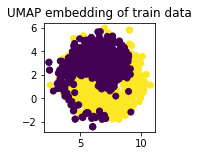

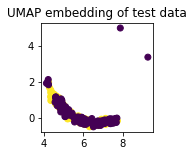

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize = (2,2))
plt.scatter(train_low[:,0], train_low[:,1], c = train_labels)
plt.title('UMAP embedding of train data');
plt.figure(figsize = (2,2))
plt.scatter(test_low[:,0], test_low[:,1], c = test_labels)
plt.title('UMAP embedding of test data')

In [11]:
# def normalize(v, r):
#     return v/np.sqrt(np.sum(v**2))*r

# Xt = np.transpose(train_low)
# XtX = np.dot(Xt,train_low)
# Xty = np.dot(Xt,train_vector.todense())
# matG = np.linalg.solve(XtX,Xty)
# Gu, Gd, Gv = np.linalg.svd(matG, full_matrices=False)

# clf = lime_evaluator.classifiers[dataset][algorithm].predict_proba

# RADIUS = 100
# gauss_ = np.random.normal(0, 1, size=train_vector.todense().shape)
# gauss_noise = gauss_
# plane_noise = np.zeros_like(gauss_noise)

# for d in range(Gv.shape[0]):
#     proj = np.dot(gauss_noise, np.transpose(Gv[d]))
#     for s in range(plane_noise.shape[0]):
#         plane_noise[s] = plane_noise[s] + proj[s]*Gv[d]        
# ortho_noise = gauss_noise - plane_noise

# # noise
# ortho_norm = normalize(ortho_noise, RADIUS)
# plane_norm = normalize(plane_noise, RADIUS)
# gauss_norm = normalize(gauss_noise, RADIUS)

# # point clouds
# ortho_pc = train_vector.todense() + ortho_norm
# plane_pc = train_vector.todense() + plane_norm
# gauss_pc = train_vector.todense() + gauss_norm

# ori_pc = train_vector.todense()

In [12]:
# data = ortho_pc
# labels = clf(data) 
# low_data = mapper.transform(data)
# low_base = mapper.transform(test_vector[0])
# distances = np.asarray([np.linalg.norm(low_data[i] - low_base) for i in range(low_data.shape[0])])
# mapping = test_vector[0].nonzero()[1]

In [179]:
# EMaP LIME
class EMaPLocalExplainer:
  def __init__(self,
               kernel_fn,
               base_data,
               clf_fn = None,
               radius = 1,
               num_samples=5000,
               lasso=True,
               mean=None,
               return_mean=False,
               return_mapped=False,
               lambda_=None,
               verbose=True,
               positive=False):
    # Transform_classifier, transform_explainer,
    # transform_explainer_to_classifier all take raw data in, whatever that is.
    # perturb(x, num_samples) returns data (perturbed data in f'(x) form),
    # inverse_data (perturbed data in x form) and mapping, where mapping is such
    # that mapping[i] = j, where j is an index for x form.
    # distance_fn takes raw data in. what we're calling raw data is just x
    self.lambda_ = lambda_
    self.kernel_fn = kernel_fn
    self.base_data = base_data
    self.radius = radius
    
    data = self.base_data
    self.mapper = umap.UMAP(n_components = 2, random_state = 21)
    self.mapper.fit(data)
    
    data_low = self.mapper.transform(data)
    Xt = np.transpose(data_low)
    XtX = np.dot(Xt,data_low)
    Xty = np.dot(Xt,data)
    self.matG = np.linalg.solve(XtX,Xty)
    Gu, Gd, Gv = np.linalg.svd(self.matG, full_matrices=False)
    
    self.noise_radius = radius
    gauss_ = np.random.normal(0, 1, size=data.shape)
    gauss_noise = gauss_
    plane_noise = np.zeros_like(gauss_noise)

    for d in range(Gv.shape[0]):
        proj = np.dot(gauss_noise, np.transpose(Gv[d]))
        for s in range(plane_noise.shape[0]):
            plane_noise[s] = plane_noise[s] + proj[s]*Gv[d]        
    ortho_noise = gauss_noise - plane_noise

    # noise
    ortho_norm = self.normalize(ortho_noise, self.radius)
    plane_norm = self.normalize(plane_noise, self.radius)
    gauss_norm = self.normalize(gauss_noise, self.radius)

    # point clouds
    self.perturbations = data + ortho_norm
    self.plane_perturbations = data + plane_norm
    self.gauss_perturbations = data + gauss_norm
    
    if clf_fn != None:
        if not hasattr(clf_fn, '__call__'):
            classifier_fn = clf_fn.predict_proba
        self.clf_fn = classifier_fn
        self.labels = self.clf_fn(self.perturbations)
    else:
        self.clf_fn = None
        self.labels = None
    
    self.low_data = self.mapper.transform(self.base_data)
    self.low_perturbations = self.mapper.transform(self.perturbations)
    
    self.num_samples = num_samples
    self.lasso = lasso
    self.mean = mean
    self.return_mapped=return_mapped
    self.return_mean = return_mean
    self.verbose = verbose
    self.positive=positive
    
  def reset(self):
    pass

  def normalize(self, v, r):
    return v/np.sqrt(np.sum(v**2))*r

  def data_labels_distances_mapping(self, raw_data, classifier_fn):
    data, labels, distances, mapping = self.data_labels_distances_mapping_fn(raw_data, classifier_fn, self.num_samples)
    return data, labels, distances, mapping

  def generate_lars_path(self, weighted_data, weighted_labels):
    X = weighted_data
    alphas, active, coefs = linear_model.lars_path(X, weighted_labels, method='lasso', verbose=False, positive=self.positive)
    return alphas, coefs

  def explain_instance_with_data(self, data, labels, distances, label, num_features):
    weights = self.kernel_fn(distances)
    weighted_data = np.asarray(data) * weights[:, np.newaxis]
    if self.mean is None:
      mean = np.mean(labels[:, label])
    else:
      mean = self.mean
    shifted_labels = labels[:, label] - mean
    if self.verbose:
      print('mean', mean)
    weighted_labels = shifted_labels * weights
    used_features = range(weighted_data.shape[1])
    nonzero = used_features
    alpha = 1
    if self.lambda_:
      classif = linear_model.Lasso(alpha=self.lambda_, fit_intercept=False, positive=self.positive)
      classif.fit(weighted_data, weighted_labels)
      used_features = classif.coef_.nonzero()[0]
      if used_features.shape[0] == 0:
        if self.return_mean:
          return [], mean
        else:
          return []
    elif self.lasso:
      alphas, coefs = self.generate_lars_path(weighted_data, weighted_labels)
      for i in range(len(coefs.T) - 1, 0, -1):
        nonzero = coefs.T[i].nonzero()[0]
        if len(nonzero) <= num_features:
            chosen_coefs = coefs.T[i]
            alpha = alphas[i]
            break
      used_features = nonzero
    debiased_model = linear_model.Ridge(alpha=0, fit_intercept=False)
    debiased_model.fit(weighted_data[:, used_features], weighted_labels)
    if self.verbose:
      print('Prediction_local', debiased_model.predict(data[0, used_features].reshape(1, -1)) + mean, 'Right:', labels[0, label])
    if self.return_mean:
      return sorted(zip(used_features,
                  debiased_model.coef_),
                  key=lambda x:np.abs(x[1]), reverse=True), mean
    else:
      return sorted(zip(used_features,
                  debiased_model.coef_),
                  key=lambda x:np.abs(x[1]), reverse=True)
  def normalize(self, v, r):
    return v/np.sqrt(np.sum(v**2))*r

  def explain_instance(self,
                       input_instance,
                       label,
                       num_features, 
                       classifier_fn = None,
                       dataset=None):
    
#     data, labels, distances, mapping = self.data_labels_distances_mapping(raw_data, classifier_fn)
    
    data = self.perturbations
    if classifier_fn != None:
        if not hasattr(classifier_fn, '__call__'):
            classifier_fn = classifier_fn.predict_proba
        labels = classifier_fn(data)
    elif self.labels.all() != None:
        labels = self.labels
    else:
        print("No classifier found")
 
    assert labels.all() != None , 'Need labels or classifier'
    
    low_data = self.low_perturbations
    low_base = self.mapper.transform(input_instance)
    distances = np.asarray([np.linalg.norm(low_data[i] - low_base) for i in range(low_data.shape[0])])
    
    return self.explain_instance_with_data(data, labels, distances, label, num_features)

#     distance_fn = lambda x : sklearn.metrics.pairwise.cosine_distances(input_instance,x)[0] * 100
#     distances = distance_fn(data)
#     mapping = input_instance.nonzero()[1]
    
    
#     if self.return_mapped:
        
#         if self.return_mean:
#             exp, mean =   self.explain_instance_with_data(data, labels, distances, label, num_features)
#         else:
#             exp =   self.explain_instance_with_data(data, labels, distances, label, num_features)
            
#         exp = [(mapping[x[0]], x[1]) for x in exp]
#         if self.return_mean:
#             return exp, mean
#         else:
#             return exp
        
#     return self.explain_instance_with_data(data, labels, distances, label, num_features), mapping

In [180]:
rho = 25
kernel = lambda d: np.sqrt(np.exp(-(d**2) / rho ** 2))
emap_explainer = EMaPLocalExplainer(kernel, 
                                    base_data = train_vector.todense(),
                                    clf_fn = lime_evaluator.classifiers[dataset][algorithm],
                                    radius = 1,
                                    num_samples=1000, 
                                    return_mean=False, 
                                    verbose=False, 
                                    return_mapped=False)
emap_explain_fn = emap_explainer.explain_instance

In [188]:
train_results, test_results = lime_evaluator.measure_explanation_hability(emap_explain_fn)

Dataset: multi_polarity_books
classifier: l1logreg


AttributeError: 'int' object has no attribute 'predict_proba'

In [185]:
index = 0
true_features = set(c_features)

topk = 10

emap_features = emap_explain_fn(test_vector[index].todense(), test_labels[index], topk, dataset=dataset)
if len(emap_features) > topk:
    emap_features_topk = set([x[0] for x in emap_features[0:topk]])
else:
    emap_features_topk = set([x[0] for x in emap_features])
lime_features = lime_explain_fn(test_vector[index], test_labels[index] ,clf, topk, dataset)

lime_feature_set = set(map(lambda x:x[0],lime_features))
emap_feature_set = set(map(lambda x:x[0],emap_features))

In [186]:
print("Recall LIME: ", float(len(true_features.intersection(lime_feature_set))) / len(true_features))
print("Recall EMaP: ", float(len(true_features.intersection(emap_feature_set))) / len(true_features))
print("Recall EMaP: ", float(len(true_features.intersection(emap_features_topk))) / len(true_features))
print("FP LIME: ", (len(lime_feature_set) - float(len(true_features.intersection(lime_feature_set)))) / len(lime_feature_set))
print("FP EMaP: ", (len(emap_feature_set) - float(len(true_features.intersection(emap_feature_set)))) / len(emap_feature_set))
print("FP EMaP: ", (len(emap_features_topk) - float(len(true_features.intersection(emap_features_topk)))) / len(emap_features_topk))

Recall LIME:  0.08108108108108109
Recall EMaP:  0.13513513513513514
Recall EMaP:  0.13513513513513514
FP LIME:  0.4
FP EMaP:  0.0
FP EMaP:  0.0


In [187]:
lime_features

[(1723, 0.07697523593714628),
 (18904, -0.06458081019716475),
 (18947, 0.05437003647283382),
 (8502, -0.039458933985327606),
 (19443, 0.0276454534359968),
 (1738, -0.01693245656703229),
 (7648, -0.003202630118523521),
 (13442, -0.002958636462666636),
 (19061, -0.002813192384892756),
 (4638, -0.002722047239596949)]

In [152]:
true_features.intersection(lime_feature_set)

{1723, 1738, 8502, 18904, 18947, 19443}

In [153]:
true_features.intersection(emap_feature_set)

{658, 1414, 6067, 7564, 10100, 11746, 11809, 18904, 18911, 19443}

In [117]:
emap_features_values = np.abs(np.asarray([x[1] for x in emap_features]))

In [119]:
emap_features_topk = np.argpartition(emap_features_values, -10)[-10:]

In [127]:
emap_features_topk = set([x[0] for x in emap_features[0:10]])

In [130]:
emap_features_topk

{1414, 2039, 4865, 5424, 6067, 7564, 11746, 11809, 18911, 19242}

In [131]:
lime_feature_set

{1597, 3068, 5318, 6171, 8529, 9170, 14426, 17444, 18204, 19061}

In [133]:
true_features.intersection(emap_features_topk)

{1414, 2039, 4865, 5424, 6067, 7564, 11746, 11809, 18911, 19242}

In [59]:
print((float(len(set(c_features).intersection(set(emap_features[0])))) / len(c_features)))

0.0


In [57]:
set(c_features)

{151,
 610,
 658,
 670,
 1414,
 1591,
 1723,
 1738,
 2010,
 2039,
 2058,
 4864,
 4865,
 5424,
 5932,
 6001,
 6020,
 6067,
 6171,
 7292,
 7340,
 7460,
 7564,
 8123,
 8173,
 8178,
 8342,
 8368,
 8502,
 9002,
 9541,
 9812,
 10100,
 10126,
 10222,
 10327,
 10330,
 10488,
 10787,
 11243,
 11389,
 11448,
 11459,
 11681,
 11746,
 11809,
 11819,
 12216,
 12389,
 13177,
 13180,
 14128,
 14162,
 14231,
 15433,
 15778,
 16120,
 16652,
 17409,
 17420,
 17691,
 18276,
 18507,
 18904,
 18911,
 18943,
 18947,
 19009,
 19049,
 19242,
 19288,
 19350,
 19414,
 19443}

In [18]:
c_features = clf.coef_.nonzero()[1]

In [19]:
c_features

array([  151,   610,   658,   670,  1414,  1591,  1723,  1738,  2010,
        2039,  2058,  4864,  4865,  5424,  5932,  6001,  6020,  6067,
        6171,  7292,  7340,  7460,  7564,  8123,  8173,  8178,  8342,
        8368,  8502,  9002,  9541,  9812, 10100, 10126, 10222, 10327,
       10330, 10488, 10787, 11243, 11389, 11448, 11459, 11681, 11746,
       11809, 11819, 12216, 12389, 13177, 13180, 14128, 14162, 14231,
       15433, 15778, 16120, 16652, 17409, 17420, 17691, 18276, 18507,
       18904, 18911, 18943, 18947, 19009, 19049, 19242, 19288, 19350,
       19414, 19443])

In [25]:
rho = 25
kernel = lambda d: np.sqrt(np.exp(-(d**2) / rho ** 2))
lime = explainers.GeneralizedLocalExplainer(kernel, explainers.data_labels_distances_mapping_text, num_samples=15000, return_mean=False, verbose=False, return_mapped=True)
lime_fn = lime.explain_instance

In [23]:
lime_fn(self.test_vectors[d][i], self.test_labels[d][i] ,self.classifiers[d][c], to_get, ))

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
lime_fn(self.test_vectors[d][i], self.test_labels[d][i] ,clf, 10, dataset))

In [32]:
print('Average test: ', np.mean(test_results[dataset][algorithm]))
out = {'train': train_results[dataset][algorithm], 'test' : test_results[dataset][algorithm]}

Average test:  0.0203940073426095


In [ ]:
data, labels, distances, mapping = self.data_labels_distances_mapping(raw_data, classifier_fn)

In [ ]:
  def measure_explanation_hability(self, explain_fn, max_examples=None):
    """Asks for explanations for all predictions in the train and test set, with
    budget = size of explanation. Returns two maps (train_results,
    test_results), from dataset to classifier to list of recalls"""
    budget = 10
    train_results = {}
    test_results = {}
    for d in self.train_data:
        train_results[d] = {}
        test_results[d] = {}
        print('Dataset:', d)
        for c in self.classifiers[d]:
            train_results[d][c] = []
            test_results[d][c] = []
            if c == 'l1logreg':
                c_features = self.classifiers[d][c].coef_.nonzero()[1]
            print('classifier:', c)
            
            for i in range(len(self.test_data[d])):
                if c == 'l1logreg':
                    true_features = set([x for x in self.test_vectors[d][i].nonzero()[1] if x in c_features])
                elif c == 'tree':
                    true_features = get_tree_explanation(self.classifiers[d][c], self.test_vectors[d][i])
                if len(true_features) == 0:
                    continue
                    
                to_get = budget
                exp_features = set(map(lambda x:x[0],
                explain_fn(self.test_vectors[d].todense()[i], self.test_labels[d][i] ,self.classifiers[d][c], to_get, d)))
                test_results[d][c].append(float(len(true_features.intersection(exp_features))) / len(true_features))
                if max_examples and i >= max_examples:
                    break
    return train_results, test_results

In [ ]:


get_tree_explanation(self.classifiers[d][c], self.test_vectors[d][i])

In [33]:
get_tree_explanation(lime_evaluator.classifiers[dataset][algorithm], lime_evaluator.test_vectors[dataset][1])

AttributeError: 'LogisticRegression' object has no attribute 'tree_'

In [36]:
set([x for x in lime_evaluator.test_vectors[dataset][0].nonzero()[1] if x in c_features])

{1723, 1738, 8502, 11459, 17409, 18904, 18947, 19443}

In [34]:
c_features = lime_evaluator.classifiers[dataset][algorithm].coef_.nonzero()[1]

In [35]:
c_features

array([  151,   610,   658,   670,  1414,  1591,  1723,  1738,  2010,
        2039,  2058,  4864,  4865,  5424,  5932,  6001,  6020,  6067,
        6171,  7292,  7340,  7460,  7564,  8123,  8173,  8178,  8342,
        8368,  8502,  9002,  9541,  9812, 10100, 10126, 10222, 10327,
       10330, 10488, 10787, 11243, 11389, 11448, 11459, 11681, 11746,
       11809, 11819, 12216, 12389, 13177, 13180, 14128, 14162, 14231,
       15433, 15778, 16120, 16652, 17409, 17420, 17691, 18276, 18507,
       18904, 18911, 18943, 18947, 19009, 19049, 19242, 19288, 19350,
       19414, 19443])